In [3]:
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [86]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from wordcloud import WordCloud,STOPWORDS

import nltk
nltk.download('punkt_tab')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

import tensorflow as tf
from tensorflow.keras.callbacks import TensorBoard
from keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers.schedules import PolynomialDecay
from tensorflow.python.ops import gen_experimental_dataset_ops

from datasets import load_dataset
from transformers import TFDistilBertForSequenceClassification, DistilBertTokenizer, DataCollatorWithPadding

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [5]:
!pip install datasets evaluate transformers[sentencepiece] -q


[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: python.exe -m pip install --upgrade pip


# Load Data

In [6]:
amazon_train = load_dataset('amazon_polarity', split='train[:10000]')
amazon_test = load_dataset('amazon_polarity', split='test[:1000]')

print("Train Dataset : ", amazon_train.shape)
print("Test Dataset : ",amazon_test.shape)

Train Dataset :  (10000, 3)
Test Dataset :  (1000, 3)


# Exploratory Data Analysis

In [7]:
amazon_train

Dataset({
    features: ['label', 'title', 'content'],
    num_rows: 10000
})

In [8]:
amazon_test

Dataset({
    features: ['label', 'title', 'content'],
    num_rows: 1000
})

In [9]:
# Preview a review from the dataset
print(amazon_train[0])

{'label': 1, 'title': 'Stuning even for the non-gamer', 'content': 'This sound track was beautiful! It paints the senery in your mind so well I would recomend it even to people who hate vid. game music! I have played the game Chrono Cross but out of all of the games I have ever played it has the best music! It backs away from crude keyboarding and takes a fresher step with grate guitars and soulful orchestras. It would impress anyone who cares to listen! ^_^'}


In [10]:
amazon_train['content']

['This sound track was beautiful! It paints the senery in your mind so well I would recomend it even to people who hate vid. game music! I have played the game Chrono Cross but out of all of the games I have ever played it has the best music! It backs away from crude keyboarding and takes a fresher step with grate guitars and soulful orchestras. It would impress anyone who cares to listen! ^_^',
 "I'm reading a lot of reviews saying that this is the best 'game soundtrack' and I figured that I'd write a review to disagree a bit. This in my opinino is Yasunori Mitsuda's ultimate masterpiece. The music is timeless and I'm been listening to it for years now and its beauty simply refuses to fade.The price tag on this is pretty staggering I must say, but if you are going to buy any cd for this much money, this is the only one that I feel would be worth every penny.",
 'This soundtrack is my favorite music of all time, hands down. The intense sadness of "Prisoners of Fate" (which means all th

In [73]:
# Define Preprocessing Variables
vocab_size = 25500
max_length = 100
trunc_type = 'post'
padding_type = 'post'
oov_token = ''
embedding_dim = 25

In [47]:
df = pd.DataFrame({'Text': amazon_train['content'], 'Label':amazon_train['label']})
df.head()

,Text,Label
0,This sound track was beautiful! It paints the ...,1
1,I'm reading a lot of reviews saying that this ...,1
2,This soundtrack is my favorite music of all ti...,1
3,I truly like this soundtrack and I enjoy video...,1
4,"If you've played the game, you know how divine...",1


In [48]:
df.loc[df['Label'] ==0]

,Text,Label
6,"This is a self-published book, and if you want...",0
10,A complete waste of time. Typographical errors...,0
13,I guess you have to be a romance novel lover f...,0
14,I feel I have to write to keep others from was...,0
15,It's glaringly obvious that all of the glowing...,0
...,...,...
9992,This is overall a real hoot! Anthony Hopkins i...,0
9993,Jim Cole has been ticketed and banned at many ...,0
9994,"As a former realtor, Mr. Cole owes the natural...",0
9997,You'd be hard-pressed to tell a boring story a...,0


In [49]:
# Define Preprocessing functions

def preprocess_text(text):
    # Remove Special character
    text = text.lower()
    text = re.sub('[^0-9a-zA-Z]',' ',text)
    # Tokenize text
    words = word_tokenize(text)
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]
    # Lemmatize words
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]
    # Join words back into a sentence
    text = ' '.join(words)
    return text

df['Text'] = df['Text'].apply(preprocess_text)

In [50]:
df['Text'][0]

'sound track beautiful paint senery mind well would recomend even people hate vid game music played game chrono cross game ever played best music back away crude keyboarding take fresher step grate guitar soulful orchestra would impress anyone care listen'

# Data Visualizations

In [51]:
# Extract text and labels
texts = df['Text'].tolist()
labels = df['Label'].tolist()

In [52]:
print(df['Label'].dtype)
print(df['Label'].unique())  # check the unique values in the label column

int64
[1 0]


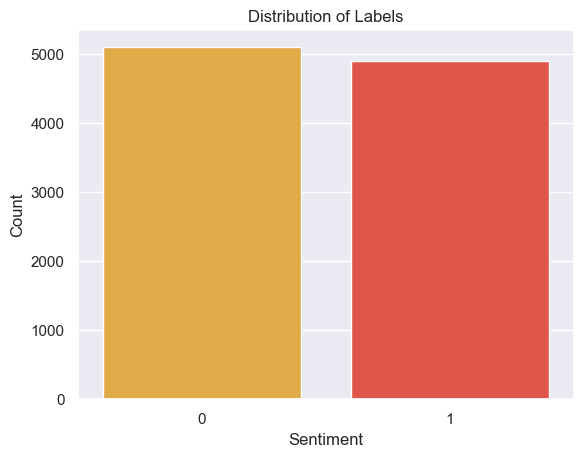

In [53]:
# Display distribution of labels

sns.set(style="darkgrid")
palette  = {'0':'#FAB12F','1': '#FA4032'} # Define color for each sentiment

sns.countplot(data=df,x='Label',palette=palette)
plt.title('Distribution of Labels')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

In [54]:
# Display example reviews

print("Example Negative Review:")
print(df[df['Label'] ==0]['Text'].iloc[67])
print("\nExample Positive Review:")
print(df[df['Label'] == 1]['Text'].iloc[43])

Example Negative Review:
read prior review record buying although appears collection new wave single 80 cover version sung starlite singer description record say various artist implying original artist true total garbage one bright spot got prompt refund returned

Example Positive Review:
man jammin track suc pokey first official record sh sooo real love production everything real nice screwed among last great suc record say fallen downsized much death screw pioneer sad true ya love tx rap got ta get 1 somethin kickback blow big somethin jam ride underrated right wish people would forget bullsh bet mtv check happening houston guess sadly almost late pat gone hawk gone screw moe pimp c big steve make sad regardless pokey still alive making new music keeping legacy alive great place start classic record love man


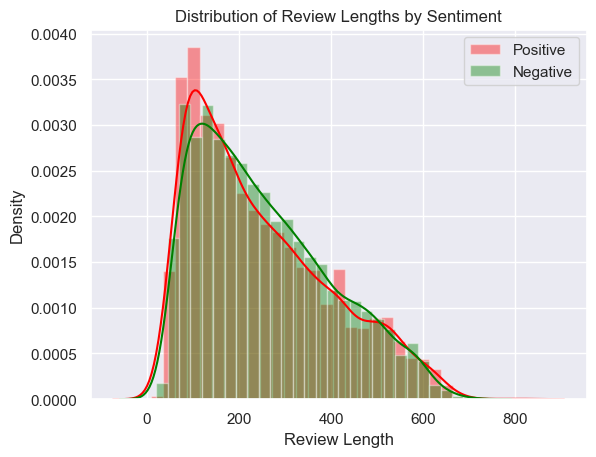

In [61]:
# Calculate the length of the reviews
positive_lengths = [len(text) for text , label in zip(texts, labels) if label == 1]
negative_lengths = [len(text) for text , label in zip(texts, labels) if label == 0]

# Create Distplot
sns.distplot(positive_lengths, label='Positive',color = 'red')
sns.distplot(negative_lengths, label='Negative',color = 'green')

plt.xlabel('Review Length')
plt.ylabel('Density')
plt.title('Distribution of Review Lengths by Sentiment')
plt.legend()

plt.show()

In [62]:
df.head()

,Text,Label
0,sound track beautiful paint senery mind well w...,1
1,reading lot review saying best game soundtrack...,1
2,soundtrack favorite music time hand intense sa...,1
3,truly like soundtrack enjoy video game music p...,1
4,played game know divine music every single son...,1


# Word Cloud

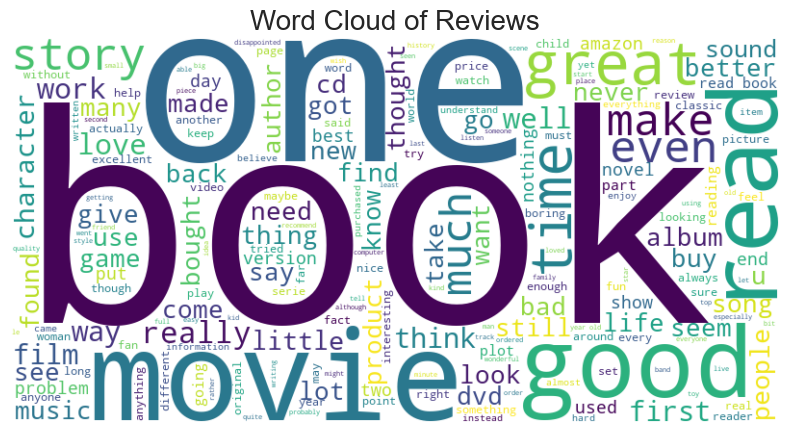

In [65]:
# Combine all text from reviews into a single string
text = ' '.join(df['Text'])

# generate the word Cloud
wordcloud = WordCloud(width = 800,height = 400, background_color = 'white',stopwords=STOPWORDS, colormap='viridis').generate(text)

# Display the word Cloud

plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Turn off the axis
plt.title('Word Cloud of Reviews', fontsize=20)
plt.show()

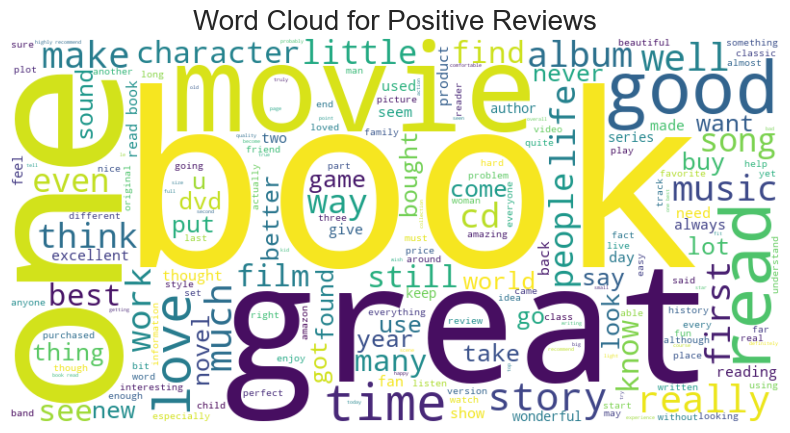

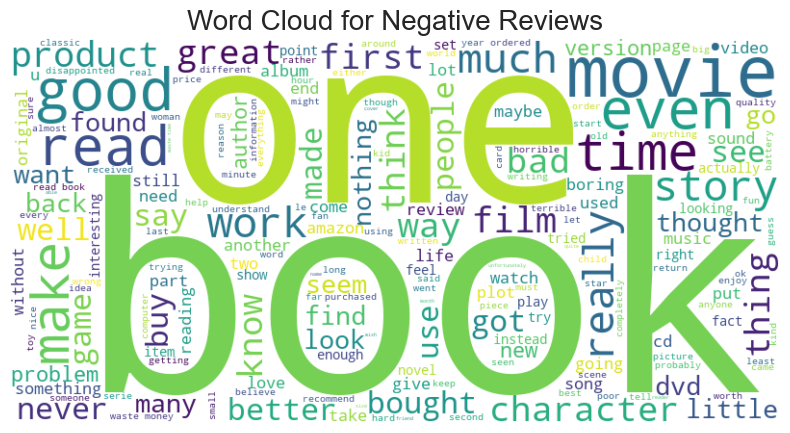

In [66]:
# Generate word clouds for each label

for label in df['Label'].unique():
    subset_text = ' '.join(df[df['Label'] == label]['Text'])


    wordcloud = WordCloud(width = 800,height = 400, background_color = 'white',stopwords=STOPWORDS, colormap='viridis').generate(subset_text)

    plt.figure(figsize=(10,5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')  # Turn off the axis
    plt.title(f'Word Cloud for {"Positive" if label == 1 else "Negative"} Reviews', fontsize=20)
    plt.show()

# Sentiment Analysis using GloVe + LSTM

In [74]:
# Preprocess data
training_sentences = [preprocess_text(sentence) for sentence in amazon_train['content']]
testing_sentences = [preprocess_text(sentence) for sentence in amazon_test['content']]

# initialize tokenizer
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_token)
tokenizer.fit_on_texts(training_sentences)

# Convert text to sequence
train_sequences = tokenizer.texts_to_sequences(training_sentences)
test_sequences =  tokenizer.texts_to_sequences(testing_sentences)

# Pad Sequences
train_padded = pad_sequences(train_sequences,maxlen=max_length,padding=padding_type,truncating=trunc_type)
test_padded = pad_sequences(test_sequences,maxlen=max_length,padding=padding_type,truncating=trunc_type)

# Get Labels
train_labels = amazon_train['label']
test_labels = amazon_test['label']

# Convert to arrays
train_padded, test_padded = np.array(train_padded), np.array(test_padded)
train_labels, test_labels = np.array(train_labels), np.array(test_labels)

In [94]:
# Load GloVe embeddings
embeddings_index = dict()

f = open(r"D:\\MachineLearning Projects\\Sentiment_Analysis_LSTM\\data\\glove.twitter.27B.25d.txt",encoding='utf8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:],dtype = 'float32')
    embeddings_index[word] = coefs
f.close()

#  Create embedding matrix
embedding_matrix = np.zeros((vocab_size,embedding_dim))
for word, index in tokenizer.word_index.items():
     if index > vocab_size - 1:
         break
     else:
         embedding_vector = embeddings_index.get(word)
         if embedding_vector is not None:
             embedding_matrix[index] = embedding_vector

# Model Experimentation

## Create LSTM Model

In [96]:
# Initialize model

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size,embedding_dim,
         weights = [embedding_matrix], trainable=False),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128)),
    tf.keras.layers.Dense(1,activation='sigmoid')
])

# Compile the model
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
            optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), 
            metrics=['accuracy']
)

# Train the model
history = model.fit(
    train_padded,
    train_labels,
    validation_data=(test_padded, test_labels),
    epochs=10
)


Epoch 1/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 17s 42ms/step - accuracy: 0.5645 - loss: 0.6783 - val_accuracy: 0.6740 - val_loss: 0.6032
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 13s 43ms/step - accuracy: 0.6976 - loss: 0.5870 - val_accuracy: 0.6920 - val_loss: 0.5765
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 14s 43ms/step - accuracy: 0.7083 - loss: 0.5749 - val_accuracy: 0.6990 - val_loss: 0.5712
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 13s 43ms/step - accuracy: 0.7182 - loss: 0.5597 - val_accuracy: 0.6970 - val_loss: 0.5642
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 14s 43ms/step - accuracy: 0.7196 - loss: 0.5517 - val_accuracy: 0.7050 - val_loss: 0.5527
Epoch 6/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 14s 43ms/step - accuracy: 0.7305 - loss: 0.5432 - val_accuracy: 0.7060 - val_loss: 0.5405
Epoch 7/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 14s 43ms/step - accuracy: 0.7349 - loss: 0.5315 - val_accuracy: 0.7110 - val_loss: 0.5449
Epoch 8/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.7335 - loss: 0.5301 - 

In [97]:
# Create function to plot loss/accuracy curves

def plot_graphs(history, string):
    plt.figure(figsize=(5,4))
    plt.plot(history.history[string])
    plt.plot(history.history['val_' + string])
    plt.xlabel("Epoches")
    plt.ylabel(string)
    plt.legend([string,'val_' + string])
    plt.show()


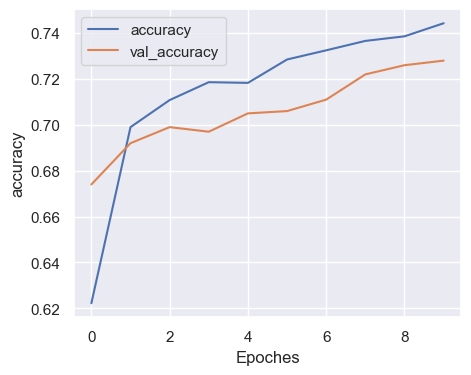

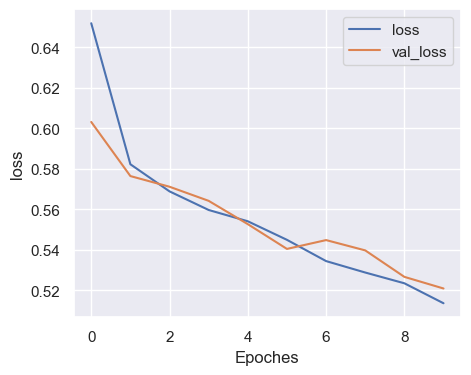

In [98]:
plot_graphs(history,"accuracy")
plot_graphs(history,"loss")

In [99]:
test_loss, test_accuracy = model.evaluate(test_padded,test_labels)
test_loss, test_accuracy

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.7370 - loss: 0.5037


(0.5209704041481018, 0.7279999852180481)

In [100]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim,
        weights=[embedding_matrix], trainable=False),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(150, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(150)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
            optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), 
            metrics=['accuracy']
)

history = model.fit(
    train_padded,
    train_labels,
    validation_data=(test_padded, test_labels),
    epochs=10
)

Epoch 1/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 49s 143ms/step - accuracy: 0.6023 - loss: 0.6538 - val_accuracy: 0.7070 - val_loss: 0.5726
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 44s 139ms/step - accuracy: 0.6968 - loss: 0.5854 - val_accuracy: 0.7090 - val_loss: 0.5567
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 43s 137ms/step - accuracy: 0.7081 - loss: 0.5636 - val_accuracy: 0.7040 - val_loss: 0.5685
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 43s 137ms/step - accuracy: 0.7179 - loss: 0.5545 - val_accuracy: 0.7150 - val_loss: 0.5518
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 43s 139ms/step - accuracy: 0.7365 - loss: 0.5300 - val_accuracy: 0.7110 - val_loss: 0.5596
Epoch 6/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 44s 139ms/step - accuracy: 0.7297 - loss: 0.5337 - val_accuracy: 0.7300 - val_loss: 0.5250
Epoch 7/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 44s 139ms/step - accuracy: 0.7441 - loss: 0.5170 - val_accuracy: 0.7300 - val_loss: 0.5233
Epoch 8/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 43s 137ms/step - accuracy: 0.7531 - loss: 0

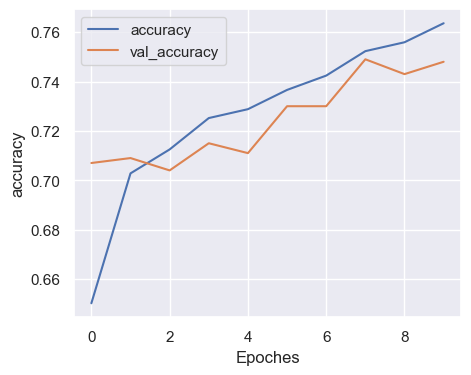

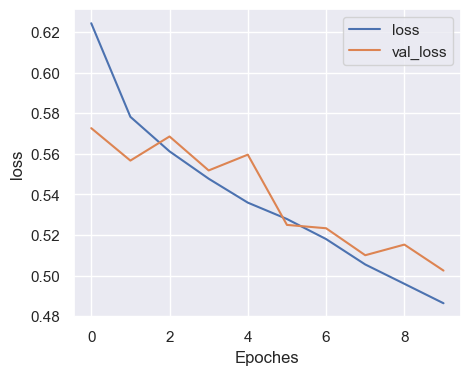

In [101]:
plot_graphs(history,"accuracy")
plot_graphs(history,"loss")

In [102]:
test_loss, test_accuracy = model.evaluate(test_padded,test_labels)
test_loss, test_accuracy

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.7530 - loss: 0.4846


(0.502466082572937, 0.7480000257492065)

# PolynominalDecay Learning rate Scheduler

In [103]:
# Define the PolynomialDecay learning rate scheduler
batch_size = 8
num_epochs = 3
num_train_steps = len(train_padded) // batch_size * num_epochs

lr_scheduler = PolynomialDecay(
    initial_learning_rate=1e-8, end_learning_rate=1e-3, decay_steps=num_train_steps
)

# Define the Adam optimizer with the learning rate scheduler
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_scheduler)

In [104]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim,
        weights=[embedding_matrix], trainable=False),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(150, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(150)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [105]:
# Compile the model
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
            optimizer=optimizer, 
            metrics=['accuracy']
)

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('../models/lstm/best_model.keras', monitor='val_loss', save_best_only=True)
tensorboard_callback = TensorBoard(log_dir='./logs', histogram_freq=1)

In [106]:
%reload_ext tensorboard
%tensorboard --logdir=./logs

In [107]:
# Train the model
history = model.fit(
    train_padded,
    train_labels,
    validation_data=(test_padded, test_labels),
    epochs=100,
    callbacks=[early_stopping, model_checkpoint, tensorboard_callback])

Epoch 1/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 50s 146ms/step - accuracy: 0.5223 - loss: 0.6886 - val_accuracy: 0.6860 - val_loss: 0.5960
Epoch 2/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 45s 144ms/step - accuracy: 0.6845 - loss: 0.5955 - val_accuracy: 0.6930 - val_loss: 0.5776
Epoch 3/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 43s 139ms/step - accuracy: 0.7085 - loss: 0.5715 - val_accuracy: 0.7040 - val_loss: 0.5612
Epoch 4/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 44s 141ms/step - accuracy: 0.7120 - loss: 0.5573 - val_accuracy: 0.7200 - val_loss: 0.5604
Epoch 5/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 45s 143ms/step - accuracy: 0.7346 - loss: 0.5346 - val_accuracy: 0.7250 - val_loss: 0.5359
Epoch 6/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 43s 138ms/step - accuracy: 0.7522 - loss: 0.5102 - val_accuracy: 0.7450 - val_loss: 0.5232
Epoch 7/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 43s 138ms/step - accuracy: 0.7581 - loss: 0.5022 - val_accuracy: 0.7690 - val_loss: 0.4822
Epoch 8/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 43s 138ms/step - accuracy: 0.7643 -

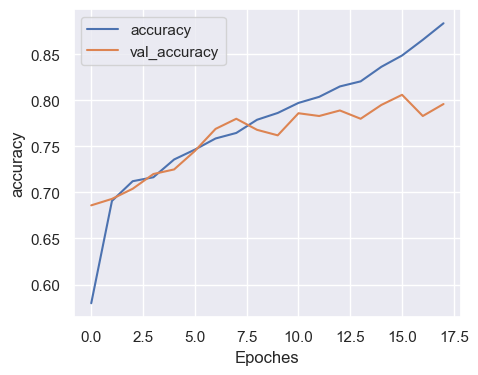

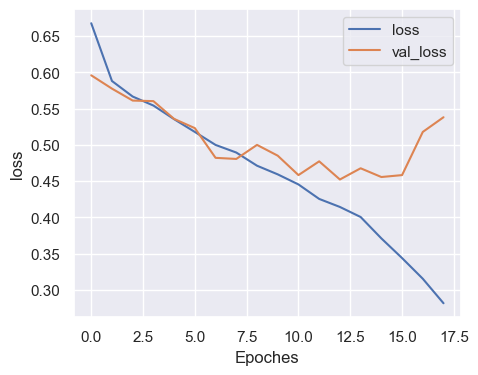

In [108]:
plot_graphs(history,"accuracy")
plot_graphs(history,"loss")

# Model Evaluations

In [109]:
best_model = tf.keras.models.load_model("D:\\MachineLearning Projects\\Sentiment_Analysis_LSTM\\models\\lstm\\best_model.keras")

# evaluation on test set
test_loss, test_accuracy = best_model.evaluate(test_padded, test_labels)

print(f'Test Accuracy: {test_accuracy*100:.2f}%')

32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.7941 - loss: 0.4378
Test Accuracy: 78.90%


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step


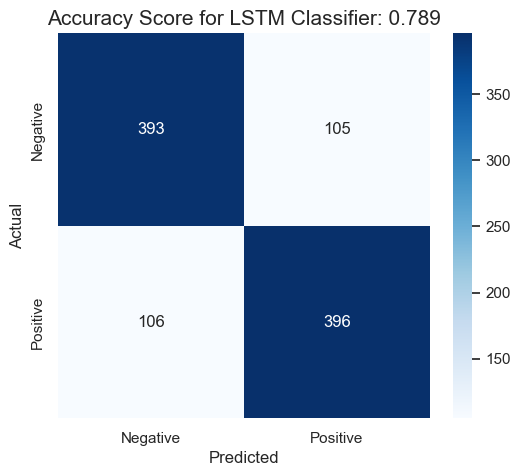

In [110]:
from sklearn.metrics import confusion_matrix

predictions = best_model.predict(test_padded)
predicted_labels = (predictions >= 0.5).astype(int)

# Generate confusion matrix
cf = confusion_matrix(test_labels, predicted_labels)
label_name=["Negative","Positive"]

plt.figure(figsize=(6,5))
sns.heatmap(cf,annot=True,fmt="d",cmap="Blues",xticklabels=label_name,yticklabels=label_name)
all_sample_title = f'Accuracy Score for LSTM Classifier: {test_accuracy:.4}'
plt.title(all_sample_title, size = 15)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

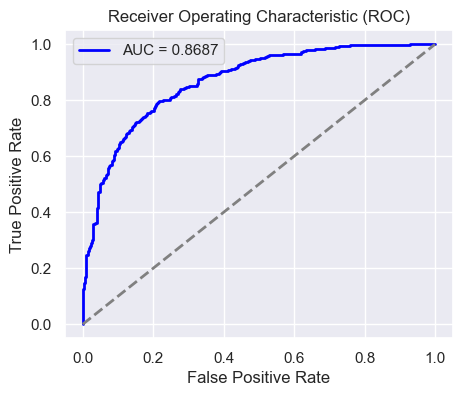

In [111]:
from sklearn.metrics import roc_curve, auc

# Flatten the 2D array into a 1D array
predictions_ravel = predictions.ravel()

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(test_labels, predictions_ravel)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(5, 4))
plt.plot(fpr, tpr, color='blue', lw=2, label='AUC = {:.4f}'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend()
plt.show()

# Model Predictions

## prediction on original data

In [112]:
import numpy as np

# Make prediction
predicted_labels = (predictions >= 0.5).astype(int)

# Create lists to store positive and negative sentences
positive_sentences = [amazon_test['content'][i] for i, pred in enumerate(predicted_labels) if pred == 1]
negative_sentences = [amazon_test['content'][i] for i, pred in enumerate(predicted_labels) if pred == 0]

In [113]:
# Print some examples
print("Positive Sentences:")
for i in range(5):  # Print first 5 positive sentences
    print(positive_sentences[i])
    print("\n")

Positive Sentences:
My lovely Pat has one of the GREAT voices of her generation. I have listened to this CD for YEARS and I still LOVE IT. When I'm in a good mood it makes me feel better. A bad mood just evaporates like sugar in the rain. This CD just oozes LIFE. Vocals are jusat STUUNNING and lyrics just kill. One of life's hidden gems. This is a desert isle CD in my book. Why she never made it big is just beyond me. Everytime I play this, no matter black, white, young, old, male, female EVERYBODY says one thing "Who was that singing ?"


I bought this charger in Jul 2003 and it worked OK for a while. The design is nice and convenient. However, after about a year, the batteries would not hold a charge. Might as well just get alkaline disposables, or look elsewhere for a charger that comes with batteries that have better staying power.


I love the style of this, but after a couple years, the DVD is giving me problems. It doesn't even work anymore and I use my broken PS2 Now. I wouldn'

In [114]:
# Print some examples
print("Negative Sentences:")
for i in range(5):  # Print first 5 negative sentences
    print(negative_sentences[i])
    print("\n")

Negative Sentences:
Despite the fact that I have only played a small portion of the game, the music I heard (plus the connection to Chrono Trigger which was great as well) led me to purchase the soundtrack, and it remains one of my favorite albums. There is an incredible mix of fun, epic, and emotional songs. Those sad and beautiful tracks I especially like, as there's not too many of those kinds of songs in my other video game soundtracks. I must admit that one of the songs (Life-A Distant Promise) has brought tears to my eyes on many occasions.My one complaint about this soundtrack is that they use guitar fretting effects in many of the songs, which I find distracting. But even if those weren't included I would still consider the collection worth it.


Check out Maha Energy's website. Their Powerex MH-C204F charger works in 100 minutes for rapid charge, with option for slower charge (better for batteries). And they have 2200 mAh batteries.


Reviewed quite a bit of the combo players 

# Prediction on sequential data

In [115]:
predicted_labels = (predictions >= 0.5).astype(int)

# Create lists of positive and negative sentences based on predicted labels 
positive_sentences = [test_padded[i] for i in range(len(predicted_labels)) if predicted_labels[i] == 1]
negative_sentences = [test_padded[i] for i in range(len(predicted_labels)) if predicted_labels[i] == 0]

positive_texts = [tokenizer.sequences_to_texts([sentence])[0] for sentence in positive_sentences]
negative_texts = [tokenizer.sequences_to_texts([sentence])[0] for sentence in negative_sentences]

In [116]:
print("Positive Texts:")
for text in range(5):
    print(positive_texts[text])
    print("\n")

Positive Texts:
lovely pat one great voice generation listened cd year still love good mood make feel better bad mood evaporates like sugar rain cd ooze life vocal   lyric kill one life hidden gem desert isle cd book never made big beyond everytime play matter black white young old male female everybody say one thing singing                                            


bought charger  2003 worked ok design nice convenient however year battery would hold charge might well get  disposable look elsewhere charger come battery better staying power                                                                        


love style couple year dvd giving problem even work anymore use broken ps2 recommend going upgrade recorder wish would work guess giving jvc really like one stopped working dvd player gave problem probably year                                                                  


firstly enjoyed format tone book author addressed reader however feel   secret book promised reve

In [117]:
print("Negative Texts:")
for text in range(5):
    print(negative_texts[text])
    print("\n")

Negative Texts:
despite fact played small portion game music heard plus connection chrono trigger great well led purchase soundtrack remains one favorite album incredible mix fun epic emotional song sad beautiful track especially like many kind song video game soundtrack must admit one song life distant promise brought tear eye many occasion one complaint soundtrack use guitar fretting effect many song find distracting even included would still consider collection worth                                


check  energy website    charger work 100 minute rapid charge option slower charge better battery   battery                                                                               


reviewed quite bit combo player hesitant due unfavorable review size machine  vhs collection want replace dvd unit well built easy setup resolution special effect progressive scan hdtv owner suitable many people looking versatile product con universal remote                                            

# Predict Sentiment Sample Text

In [118]:
def predict_sentiment(input_text):
    # Preprocess input text
    inputs = tokenizer.texts_to_sequences([input_text])
    padded = pad_sequences(inputs, maxlen=max_length,
                    padding=padding_type, truncating=trunc_type)

    # Get model prediction
    preiction = model.predict(padded)
    predicted_class = (preiction >= 0.5).astype(int)

    # Determine sentiment label
    sentiment_label = "positive" if predicted_class == 1 else "negative"

    return sentiment_label

In [119]:
# Postive test sample
input_text = "I am extremely happy with this product. It exceeded my expectations in every way. The quality is top-notch, and it has greatly improved my daily routine. I highly recommend it to others!"
predicted_sentiment = predict_sentiment(input_text)
print(f"The sentiment is {predicted_sentiment}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step
The sentiment is positive


In [120]:
# Negative test sample
input_text = "Extremely terrible experience. The product was of very low quality and stopped working after just a few days of use. I would not recommend this to anyone"
predicted_sentiment = predict_sentiment(input_text)
print(f"The sentiment is {predicted_sentiment}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
The sentiment is negative
